In [1]:
import numpy as np
import scipy as sp
import scipy.constants
from sympy.physics.wigner import wigner_6j
from sympy.physics.wigner import wigner_3j
import matplotlib.pyplot as plt
from scipy.stats import norm
import tqdm
import random

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon_0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
e0 = sp.constants.e
a0 = sp.constants.physical_constants["Bohr radius"][0]
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]
g = sp.constants.g

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41


In [2]:
def light_shift(F, mF, Psingle):
    
    ground = -9.475*1e-4
    f32mf32 = -3.7*1e-4
    f32mf12 = -7.5*1e-4
    f12mf12 = -7.5*1e-4
    
    if F==1/2:
        excited = f12mf12
    elif F==3/2 and abs(mF)==3/2:
        excited = f32mf32
    elif F==3/2 and abs(mF)==1/2:
        excited = f32mf12
        

    w0 = 0.46e-6 #tweezer waist    
    I0 = 2*Psingle/pi/w0**2 #max intensity
    
    return (excited-ground)*I0*h

In [3]:
def Zeeman_shift(F, mF, B):

    L = 1
    S = 1
    J = 1
    I = 1/2

    gJ = 3/2 + (S*(S+1) - L*(L+1)) / 2 / J / (J+1)  
    gF = (F*(F+1) + J*(J+1) - I*(I+1)) / 2 / F / (F+1) * gJ

    return mB*gF*B*mF

In [4]:
def KE(vx, vy, vz):
    return(m*(vx**2+vy**2+vz**2)/2)

def PE(x, y, z):
    return -U*(1 - 2*(x**2+y**2)/w0**2 - (z/zR)**2)

In [34]:
#monte-carlo for temp measurement

m = 171*u #mass
P = 6.08e-3 #tweezer power (85% loss from clipping, 92% objective tranmission)
alpha0 = 37.9e-4 #Hz/W/m-2 from Takahashi
_lambda = 532e-9 #532 wavelength
k = 2*np.pi/_lambda
gamma = 2*np.pi*180e3
Isat = 0.138e-3/1e-4
Pgreen = 4*2.5e-3 + 2e-3
Igreen = Pgreen/np.pi/(2e-3)**2*2
w0 = 0.46e-6 #waist at 532 (from Zemax design is 0.4 um)
zR = pi*w0**2/ _lambda #Rayleigh range
I0 = 2*P /pi/w0**2
U = h*I0*alpha0/4
omg_r = np.sqrt(4*U/m/w0**2)
omg_ax = np.sqrt(2*U/m/zR**2)
T = 10e-6
F=3/2
mF_arr=[-3/2, -1/2, 1/2, 3/2]

In [38]:
def Doppler(v, r, delta):
    F = hbar*k*(gamma/2)**3*( 1/((delta-k*v)**2 + (gamma/2)**2) -  1/((delta+k*v)**2 + (gamma/2)**2)) * Igreen/Isat
    return F*r

In [40]:
Doppler(v_std, rpos_std, 1e6)/h

7470873.218231329

In [52]:
v_std = np.sqrt(kB*T/m)
rpos_std = np.sqrt(kB*T/m/omg_r**2)
axpos_std = np.sqrt(kB*T/m/omg_ax**2)

Ntraj = 1000
tN = 1000
dt = 1e-5

rmin = 100e-9 #closest distance for collision to occur

xs1 = norm.rvs(size=Ntraj, scale=rpos_std)
ys1 = norm.rvs(size=Ntraj, scale=rpos_std)
zs1 = norm.rvs(size=Ntraj, scale=axpos_std)
vxs1 = norm.rvs(size=Ntraj, scale=v_std)
vys1 = norm.rvs(size=Ntraj, scale=v_std)
vzs1 = norm.rvs(size=Ntraj, scale=v_std)

xs2 = norm.rvs(size=Ntraj, scale=rpos_std)
ys2 = norm.rvs(size=Ntraj, scale=rpos_std)
zs2 = norm.rvs(size=Ntraj, scale=axpos_std)
vxs2 = norm.rvs(size=Ntraj, scale=v_std)
vys2 = norm.rvs(size=Ntraj, scale=v_std)
vzs2 = norm.rvs(size=Ntraj, scale=v_std)

B_arr = np.linspace(0, 15e-4, 50)
Delta_arr = np.linspace(-2*np.pi*20e6, 2*np.pi*40e6, 50)

load_all = []
for i in range(len(Delta_arr)):
    Delta = Delta_arr[i]
    for j in range(len(B_arr)):
        B = B_arr[j]
        load = 0

        for n in range(Ntraj):
            Eint = 0

            #1st particle
            x1 = xs1[n]
            y1 = ys1[n]
            z1 = zs1[n]
            vx1 = vxs1[n]
            vy1 = vys1[n]
            vz1 = vzs1[n]

            #2nd particle
            x2 = xs2[n]
            y2 = ys2[n]
            z2 = zs2[n]
            vx2 = vxs2[n]
            vy2 = vys2[n]
            vz2 = vzs2[n]

            t = 0

            while t<tN:

                vx1 = vx1 + np.sqrt(abs(2*Ed1)*m/3)
                vy1 = vy1 + np.sqrt(abs(2*Ed1)*m/3)
                vz1 = vz1 + np.sqrt(abs(2*Ed1)*m/3)

                x1 = x1 + vx1*dt
                y1 = y1 + vy1*dt
                z1 = z1 + vz1*dt - g*dt**2

                r1 = np.sqrt(x1**2 + y1**2 + z1**2)
                dr1 = np.sqrt((vx1*dt)**2 + (vy1*dt)**2 + (vz1*dt - g*dt**2)**2)
                v1 = np.sqrt(vx1**2 + vy1**2 + vz1**2)

                vx2 = vx2 - np.sqrt(abs(2*Ed2)*m/3)
                vy2 = vy2 - np.sqrt(abs(2*Ed2)*m/3)
                vz2 = vz2 - np.sqrt(abs(2*Ed2)*m/3)

                x2 = x2 + vx2*dt
                y2 = y2 + vy2*dt
                z2 = z2 + vz2*dt - g*dt**2

                r2 = np.sqrt(x2**2 + y2**2 + z2**2)
                dr2 = np.sqrt((vx2*dt)**2 + (vy2*dt)**2 + (vz2*dt - g*dt**2)**2)
                v2 = np.sqrt(vx2**2 + vy2**2 + vz2**2)

                E1 = KE(vx1, vy1, vz1) + PE(x1, y1, z1)
                E2 = KE(vx2, vy2, vz2) + PE(x2, y2, z2)
                
                r = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
                
                Ed1 = 0
                Ed2 = 0
                
                for mF in mF_arr:
                    resonance = (Zeeman_shift(F, mF, B) + light_shift(F, mF, P))/hbar
                    Ed1 += Doppler(v1, dr1, Delta-resonance)
                    Ed2 += Doppler(v1, dr2, Delta-resonance)
                

                #if r<rmin:
                #    mF = random.choice(mF_arr) #excited state mF level for blue-shielding enhanced loading

                #    mF1 = random.choice([-1/2, 1/2])
                #    mF2 = random.choice([-1/2, 1/2])

                #    if abs(mF-mF1)>1 or abs(mF-mF2)>1:
                #        Eint = 0
                        

                #    else:
                #        resonance = Zeeman_shift(F, mF, B) + light_shift(F, mF, P)
                #        Eint = hbar*Delta - resonance
                #        if Eint < 0:
                #            Eint = 0

                #else:
                Eint = 0
                
                Etot = E1+E2 + Eint + Ed1 + Ed2

                if Etot > 2*U:
                    load += 0
                    #print('lost')
                    t = tN

                elif Etot > U:
                    load += 1
                    #print('load')
                    t = tN

                else:
                    t += 1



        load_all.append(load)




In [50]:

Elevels_all = []
for mF in mF_arr: 
    Elevels = []
    for b in B_arr:
        Elevels.append( (Zeeman_shift(F, mF, b) + light_shift(F, mF, P))/h*1e-6 )
    Elevels_all.append(Elevels)


Text(0.5, 0, 'B field in G')

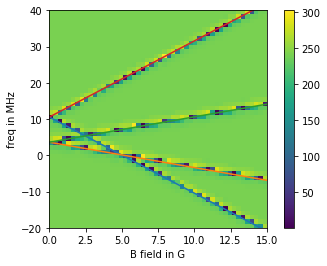

In [51]:
mF_name = ['-3/2', '-1/2', '+1/2', '+3/2']
for i, mF in enumerate(mF_arr):
    plt.plot(B_arr*1e4, Elevels_all[i], label = 'F=3/2,'+'mF='+mF_name[i])
plt.imshow(np.array(load_all).reshape(50,50), origin='lower', extent=[B_arr[0]*1e4, B_arr[-1]*1e4, Delta_arr[0]/1e6/2/np.pi, Delta_arr[-1]/1e6/2/np.pi], 
           aspect =(B_arr[0]*1e4-B_arr[-1]*1e4)/(Delta_arr[0]/1e6/2/np.pi-Delta_arr[-1]/1e6/2/np.pi))
plt.colorbar()
plt.ylabel('freq in MHz')
plt.xlabel('B field in G')